In [1]:
# import packages
import zipfile
import urllib.request

import pandas as pd
import numpy as np
import sklearn.metrics
import sklearn.ensemble
import sklearn.model_selection

from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

import optuna

In [2]:
# download pre-trained GloVe vectors from the website
URL = 'https://nlp.stanford.edu/data/glove.6B.zip'
FILE_NAME = 'glove.6B.zip'
urllib.request.urlretrieve(URL, FILE_NAME)

with zipfile.ZipFile(FILE_NAME, 'r') as zip_ref:
    zip_ref.extractall()

# transfer pre-trained GloVe vectors into word2vec format
GLOVE_FILE = 'glove.6B.100d.txt'
WORD2VEC_FILE = GLOVE_FILE + '.word2vec'
glove2word2vec(GLOVE_FILE, WORD2VEC_FILE)

# load pre-trained GloVe vectors
glove_model = KeyedVectors.load_word2vec_format(WORD2VEC_FILE, binary=False)

/var/folders/gy/5v8v142s4fz6nz5xwllrz4b40000gn/T/ipykernel_14900/779987310.py:12: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(GLOVE_FILE, WORD2VEC_FILE)


In [3]:
# load dataset
df1 = pd.read_excel('../../Downloads/CHEME DIRECT/NLP Project/PSE Dataset.xlsx', sheet_name='SamePerson Report')
df2 = pd.read_excel('../../Downloads/CHEME DIRECT/NLP Project/PSE Dataset.xlsx', sheet_name='Multiple People Report')
df3 = pd.read_excel('../../Downloads/CHEME DIRECT/NLP Project/PSE Dataset.xlsx', sheet_name='Multiple People Less Details')

In [4]:
dev_1, test_1 = sklearn.model_selection.train_test_split(df1, test_size=0.2, random_state=26)
dev_2, test_2 = sklearn.model_selection.train_test_split(df2, test_size=0.2, random_state=26)
dev_3, test_3 = sklearn.model_selection.train_test_split(df3, test_size=0.2, random_state=26)

In [5]:
dev_1_text = dev_1['Report'].values.reshape(-1,1)
test_1_text = test_1['Report'].values.reshape(-1,1)

dev_1_label = dev_1['Level'].values.reshape(-1,1)
test_1_label = test_1['Level'].values.reshape(-1,1)

dev_2_text = dev_2['Report'].values.reshape(-1,1)
test_2_text = test_2['Report'].values.reshape(-1,1)

dev_2_label = dev_2['Level'].values.reshape(-1,1)
test_2_label = test_2['Level'].values.reshape(-1,1)

dev_3_text = dev_3['Report'].values.reshape(-1,1)
test_3_text = test_3['Report'].values.reshape(-1,1)

dev_3_label = dev_3['Level'].values.reshape(-1,1)
test_3_label = test_3['Level'].values.reshape(-1,1)

In [6]:
# define functions for tokenizing the text data
class Word2VecVectorizer:
    def __init__(self, model_vec):
        print("Loading in word vectors...")
        self.word_vectors = model_vec
        print("Finished loading in word vectors")

    def fit(self, data):
        """fit data"""

    def transform(self, data):
        """determine the dimensionality of vectors"""
        v_get = self.word_vectors.get_vector('king')
        self.D = v_get.shape[0]

        x_vec = np.zeros((len(data), self.D))
        n_count = 0
        emptycount = 0

        for sentence in data:
            tokens = sentence.split()
            vecs = []
            m_count = 0
            for word in tokens:
                try:
                    # throws KeyError if word not found
                    vec = self.word_vectors.get_vector(word)
                    vecs.append(vec)
                    m_count += 1
                except KeyError:
                    pass

            if len(vecs) > 0:
                vecs = np.array(vecs)
                x_vec[n_count] = vecs.mean(axis=0)
            else:
                emptycount += 1
            n_count += 1

        print("Numer of samples with no words found: %s / %s" % (emptycount,
        	len(data)))
        return x_vec

    def fit_transform(self, data):
        """transform the strings to vectors"""
        self.fit(data)

        return self.transform(data)

In [7]:
dev_1_text_list = dev_1_text.tolist()
dev_1_text_str = [item for sublist in dev_1_text_list for item in sublist]

test_1_text_list = test_1_text.tolist()
test_1_text_str = [item for sublist in test_1_text_list for item in sublist]

dev_1_label_list = dev_1_label.tolist()
dev_1_label_str = [item for sublist in dev_1_label_list for item in sublist]

test_1_label_list = test_1_label.tolist()
test_1_label_str = [item for sublist in test_1_label_list for item in sublist]

In [24]:
dev_2_text_list = dev_2_text.tolist()
dev_2_text_str = [item for sublist in dev_2_text_list for item in sublist]

test_2_text_list = test_2_text.tolist()
test_2_text_str = [item for sublist in test_2_text_list for item in sublist]

dev_2_label_list = dev_2_label.tolist()
dev_2_label_str = [item for sublist in dev_2_label_list for item in sublist]

test_2_label_list = test_2_label.tolist()
test_2_label_str = [item for sublist in test_2_label_list for item in sublist]

In [25]:
dev_3_text_list = dev_3_text.tolist()
dev_3_text_str = [item for sublist in dev_3_text_list for item in sublist]

test_3_text_list = test_3_text.tolist()
test_3_text_str = [item for sublist in test_3_text_list for item in sublist]

dev_3_label_list = dev_3_label.tolist()
dev_3_label_str = [item for sublist in dev_3_label_list for item in sublist]

test_3_label_list = test_3_label.tolist()
test_3_label_str = [item for sublist in test_3_label_list for item in sublist]

In [26]:
dev_text = dev_1_text_str + dev_2_text_str + dev_3_text_str
test_text = test_1_text_str + test_2_text_str + test_3_text_str

dev_label = dev_1_label_str + dev_2_label_str + dev_3_label_str
test_label = test_1_label_str + test_2_label_str + test_3_label_str

In [27]:
# set a word vectorizer
vectorizer = Word2VecVectorizer(glove_model)

# get the sentence embeddings for the train dataset
dev_x = vectorizer.fit_transform(dev_text)
dev_y = dev_label

# get the sentence embeddings for the test dataset
test_x = vectorizer.transform(test_text)
test_y = test_label

Loading in word vectors...
Finished loading in word vectors
Numer of samples with no words found: 0 / 240
Numer of samples with no words found: 0 / 60


In [28]:
train_x, val_x, train_y, val_y = sklearn.model_selection.train_test_split(
    dev_x, dev_y, test_size=0.2, random_state=26)

In [29]:
def train_evaluate_hyperparameters(n_estimators, max_depth, min_weight_fraction_leaf):
    # create model
    model = sklearn.ensemble.RandomForestClassifier(
        n_estimators=n_estimators, max_depth=max_depth, min_weight_fraction_leaf=min_weight_fraction_leaf)
    # train the model on the training set
    model.fit(train_x, train_y)
    # evaluate the model on the validation set
    score = model.score(val_x, val_y)
    return score

In [30]:
def objective(trial):
    # define hyperparameter space
    n_estimators = trial.suggest_int('n_estimators', 100, 5000)
    max_depth = trial.suggest_int('max_depth', 1, 600)
    min_weight_fraction_leaf = trial.suggest_uniform(
        'min_weight_fraction_leaf', 0.0, 0.5)
    
    # get the score for the hyperparameters chosen
    score = train_evaluate_hyperparameters(n_estimators, max_depth, min_weight_fraction_leaf)
    return score

study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='maximize')
study.optimize(objective, n_trials=50)
print('Best params: ', study.best_params)

[I 2023-06-04 23:00:10,526] A new study created in memory with name: no-name-ab58661e-55da-4978-a88d-424f115f6400
/var/folders/gy/5v8v142s4fz6nz5xwllrz4b40000gn/T/ipykernel_14900/1728467643.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  min_weight_fraction_leaf = trial.suggest_uniform(
[I 2023-06-04 23:00:12,872] Trial 0 finished with value: 0.4583333333333333 and parameters: {'n_estimators': 3737, 'max_depth': 237, 'min_weight_fraction_leaf': 0.12819436665541983}. Best is trial 0 with value: 0.4583333333333333.
/var/folders/gy/5v8v142s4fz6nz5xwllrz4b40000gn/T/ipykernel_14900/1728467643.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  min_weight_fraction_leaf = trial.suggest_uniform(
[I 2023-06-04

/var/folders/gy/5v8v142s4fz6nz5xwllrz4b40000gn/T/ipykernel_14900/1728467643.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  min_weight_fraction_leaf = trial.suggest_uniform(
[I 2023-06-04 23:00:48,466] Trial 15 finished with value: 0.6666666666666666 and parameters: {'n_estimators': 4974, 'max_depth': 18, 'min_weight_fraction_leaf': 0.008440029412940517}. Best is trial 15 with value: 0.6666666666666666.
/var/folders/gy/5v8v142s4fz6nz5xwllrz4b40000gn/T/ipykernel_14900/1728467643.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  min_weight_fraction_leaf = trial.suggest_uniform(
[I 2023-06-04 23:00:49,757] Trial 16 finished with value: 0.2708333333333333 and parameters: {'n_estimators': 2569, 'max_dept

/var/folders/gy/5v8v142s4fz6nz5xwllrz4b40000gn/T/ipykernel_14900/1728467643.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  min_weight_fraction_leaf = trial.suggest_uniform(
[I 2023-06-04 23:01:29,625] Trial 30 finished with value: 0.4791666666666667 and parameters: {'n_estimators': 2932, 'max_depth': 252, 'min_weight_fraction_leaf': 0.08674805571547699}. Best is trial 15 with value: 0.6666666666666666.
/var/folders/gy/5v8v142s4fz6nz5xwllrz4b40000gn/T/ipykernel_14900/1728467643.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  min_weight_fraction_leaf = trial.suggest_uniform(
[I 2023-06-04 23:01:33,774] Trial 31 finished with value: 0.625 and parameters: {'n_estimators': 4956, 'max_depth': 228, 'min

/var/folders/gy/5v8v142s4fz6nz5xwllrz4b40000gn/T/ipykernel_14900/1728467643.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  min_weight_fraction_leaf = trial.suggest_uniform(
[I 2023-06-04 23:02:20,097] Trial 45 finished with value: 0.5208333333333334 and parameters: {'n_estimators': 4438, 'max_depth': 26, 'min_weight_fraction_leaf': 0.05900845885564565}. Best is trial 15 with value: 0.6666666666666666.
/var/folders/gy/5v8v142s4fz6nz5xwllrz4b40000gn/T/ipykernel_14900/1728467643.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  min_weight_fraction_leaf = trial.suggest_uniform(
[I 2023-06-04 23:02:23,106] Trial 46 finished with value: 0.6458333333333334 and parameters: {'n_estimators': 3765, 'max_depth

Best params:  {'n_estimators': 4974, 'max_depth': 18, 'min_weight_fraction_leaf': 0.008440029412940517}


In [31]:
# train a Random Forest model
model = sklearn.ensemble.RandomForestClassifier(
    n_estimators=4974, min_weight_fraction_leaf=0.008440029412940517, max_depth=18)

model.fit(dev_x, dev_y)

RandomForestClassifier(max_depth=18,
                       min_weight_fraction_leaf=0.008440029412940517,
                       n_estimators=4974)

In [32]:
# accuracy report
print("model accuracy:", model.score(test_x, test_y))

predict_y = model.predict(test_x)

print(sklearn.metrics.classification_report(test_y, predict_y, digits=4))

model accuracy: 0.6833333333333333
              precision    recall  f1-score   support

           1     0.9286    1.0000    0.9630        13
           2     0.5625    0.8182    0.6667        11
           3     0.6250    0.2778    0.3846        18
           4     0.5000    0.5556    0.5263         9
           5     0.7500    1.0000    0.8571         9

    accuracy                         0.6833        60
   macro avg     0.6732    0.7303    0.6795        60
weighted avg     0.6793    0.6833    0.6538        60



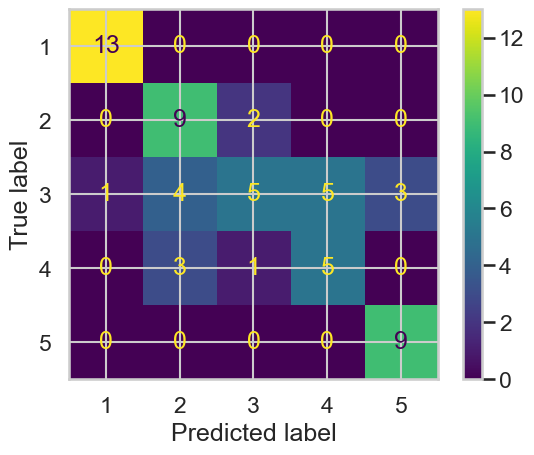

In [33]:
# plot a confusion matrix
sklearn.metrics.ConfusionMatrixDisplay.from_estimator(model, test_x, test_y)